### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [3]:
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 19.8 MB/s eta 0:00:0000:0100:01


In [1]:
import os
import cv2

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18330020905524634786
xla_global_id: -1
]


In [3]:
os.listdir('data')

['ant-1.6-preprop', 'log4j-1.0', 'log4j-1.1', 'poi-3.0-preprop']

In [152]:
train_dir = "data/poi-3.0-preprop/"
valid_dir = "data/ant-1.6-preprop/"

In [161]:
img_height,img_width=180,180
batch_size= 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              validation_split=0.2,
                                                              subset="training",
                                                              seed=123,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              seed=123,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)

Found 433 files belonging to 2 classes.
Using 347 files for training.
Found 349 files belonging to 2 classes.
Using 69 files for validation.


In [162]:
class_names = train_ds.class_names
print(class_names)

['buggy', 'clean']


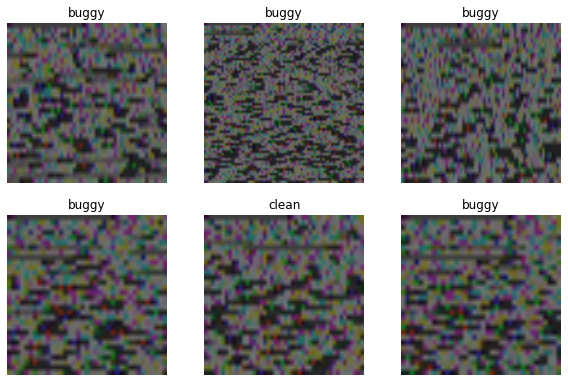

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [164]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                 input_shape=(180,180,3),
                                                 pooling='avg',
                                                 classes=2,
                                                 weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [165]:
resnet_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 512)               1049088   
                                                                 
 dense_31 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [166]:
len(resnet_model.layers)

4

In [167]:
resnet_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [168]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 65s 6s/step - loss: 1.3067 - accuracy: 0.6138 - val_loss: 4.8763 - val_accuracy: 0.3043
Epoch 2/10
11/11 [==============================] - 66s 6s/step - loss: 0.9214 - accuracy: 0.7233 - val_loss: 2.0324 - val_accuracy: 0.3043
Epoch 3/10
11/11 [==============================] - 70s 7s/step - loss: 0.5893 - accuracy: 0.7435 - val_loss: 1.0694 - val_accuracy: 0.3188
Epoch 4/10
11/11 [==============================] - 69s 6s/step - loss: 0.4589 - accuracy: 0.7954 - val_loss: 1.3157 - val_accuracy: 0.3623
Epoch 5/10
11/11 [==============================] - 57s 5s/step - loss: 0.4028 - accuracy: 0.8156 - val_loss: 1.0911 - val_accuracy: 0.3623
Epoch 6/10
11/11 [==============================] - 58s 5s/step - loss: 0.4055 - accuracy: 0.8127 - val_loss: 0.8534 - val_accuracy: 0.4928
Epoch 7/10
11/11 [==============================] - 57s 5s/step - loss: 0.3923 - accuracy: 0.8242 - val_loss: 0.7771 - val_accuracy: 0.4783
Epoch 8/10
11/11 [==

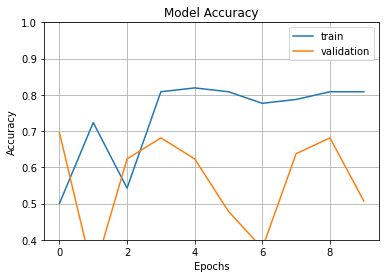

In [59]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

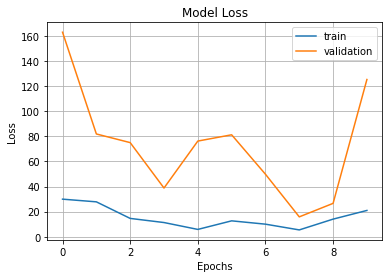

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [31]:
model_json = resnet_model.to_json()
with open('sdp_resnet_model.json','w') as json_file:
    json_file.write(model_json)
    
resnet_model.save_weights('resnet_model.h5')

In [32]:
with open('sdp_resnet_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('resnet_model.h5')
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,616,453
Trainable params: 1,051,653
Non-trainable params: 23,564,800
_________________________________________________________________


In [33]:
import numpy as np
import cv2
def predict(x):
    image=cv2.imread(x)
    plt.imshow(image)
    image_resized= cv2.resize(image, (180,180))
    image=np.expand_dims(image_resized,axis=0)
    print(image.shape)
    pred=resnet_model.predict(image)
    print(pred)
    output_class=class_names[np.argmax(pred)]
    print("The predicted is", output_class)

(1, 180, 180, 3)


ValueError: in user code:

    File "C:\Users\Aldi\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Aldi\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Aldi\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Aldi\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Aldi\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Aldi\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 180, 180, 3)


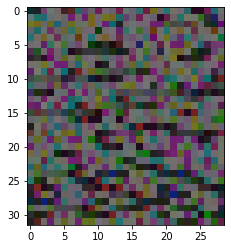

In [34]:
predict("data/log4j-1.1/clean/AbsoluteTimeDateFormat.png")